## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Зеленцов Алексей Викторович

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import *
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

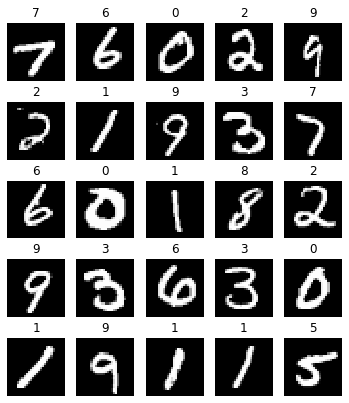

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer_norm(layer, size, next_size): #unused argument for interface
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.0, std=0.1)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer_norm(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
def experiment1(func_init):
    layers = []
    sizes = [28*28] + [500]*10 + [10]
    for size, next_size in zip(sizes, sizes[1:]):
        layer = nn.Linear(size, next_size)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

        func_init(layer, size, next_size)

        layers.append(layer)
        layers.append(nn.Tanh())

    module = nn.Sequential(*layers)


    X = images_train.reshape(-1, 28*28)
    res = module(X)
    res.mean().backward()

In [8]:
experiment1(init_layer_norm)

forward 0.984962522983551
forward 0.8464657664299011
forward 0.7871167063713074
forward 0.7741717100143433
forward 0.7684016823768616
forward 0.7689638733863831
forward 0.7642598748207092
forward 0.7621573805809021
forward 0.7652718424797058
forward 0.7643900513648987
forward 0.7631269693374634
backward 0.004417624790221453
backward 0.0053988490253686905
backward 0.005111518315970898
backward 0.00488974479958415
backward 0.004713031463325024
backward 0.004629644565284252
backward 0.004588901065289974
backward 0.004733691923320293
backward 0.004864195361733437
backward 0.005072848405689001
backward 0.0042649670504033566


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
def init_layer_xavier(layer, size, next_size):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-np.sqrt(6)/np.sqrt(size + next_size), np.sqrt(6)/np.sqrt(size + next_size))

In [10]:
experiment1(init_layer_xavier)

forward 0.984962522983551
forward 0.6485791206359863
forward 0.4965828061103821
forward 0.4195516109466553
forward 0.3619062602519989
forward 0.32178255915641785
forward 0.29178526997566223
forward 0.26956626772880554
forward 0.25072208046913147
forward 0.2366744875907898
forward 0.22573791444301605
backward 0.0035768102388828993
backward 0.016365688294172287
backward 0.01527674961835146
backward 0.014165104366838932
backward 0.011897127144038677
backward 0.01107486616820097
backward 0.009891057386994362
backward 0.008146243169903755
backward 0.006894780322909355
backward 0.005059225019067526
backward 0.0029795016162097454


In [11]:
def init_layer_he(layer, size, next_size):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.0, std=2/size)

In [12]:
experiment1(init_layer_he)

forward 0.984962522983551
forward 0.07018296420574188
forward 0.006184844300150871
forward 0.0005482595297507942
forward 4.8778962081996724e-05
forward 4.376560355012771e-06
forward 3.897566784871742e-07
forward 3.4919974467584325e-08
forward 3.0965043862352104e-09
forward 2.832029610821962e-10
forward 2.518875732993031e-11
backward 0.0
backward 0.0012442696606740355
backward 0.00010923466470558196
backward 9.616669558454305e-06
backward 8.051942472775409e-07
backward 7.546859137619322e-08
backward 6.784352191147036e-09
backward 6.125084883734644e-10
backward 5.405464270635818e-11
backward 4.917427576245359e-12
backward 4.3105666605591786e-13


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [13]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        w, b = self.linear.parameters()        

        if self.training:
            mask = torch.zeros_like(w).bernoulli_(self.p)                        
        else:
            mask = torch.ones_like(w) * self.p
        
        mask = mask.data
        mask.requires_grad=False
        output = torch.mm(x, (w*mask).transpose(0, 1)) + b
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 4... (Train/Test) NLL: 0.147/0.160	Accuracy: 0.961/0.962


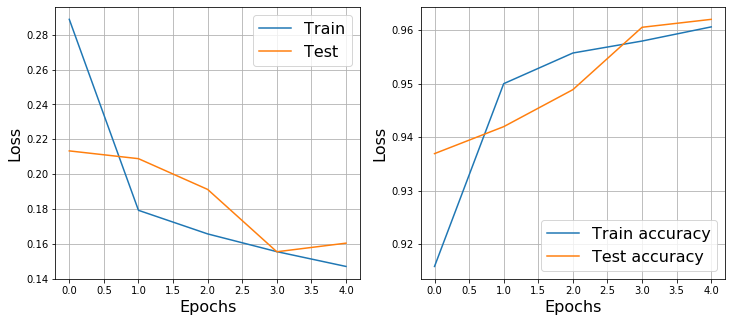

([0.28876946990423874,
  0.17924576990608213,
  0.16571642076378185,
  0.15554339036361367,
  0.14705270188036504],
 [0.21332473897292645,
  0.20886807775572885,
  0.19123318549127707,
  0.15547894686460495,
  0.1604117364681597],
 [0.91580045, 0.9499933, 0.9557291, 0.95796686, 0.96061546],
 [0.93690664, 0.94195014, 0.9488726, 0.9605419, 0.96202534])

In [14]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.02))
    else:
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)

train(net, train_loader, test_loader, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.152/0.162	Accuracy: 0.960/0.960


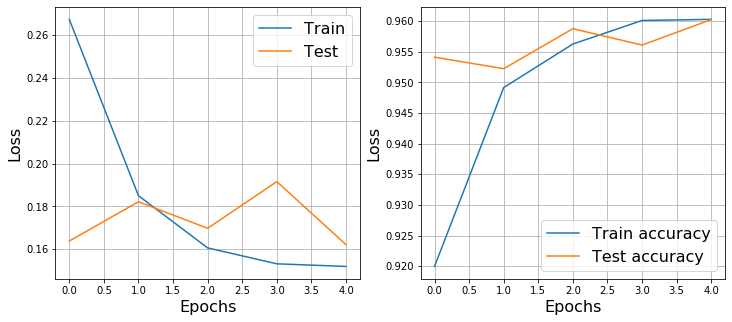

([0.2673801835983801,
  0.18497270491045675,
  0.16059230595255203,
  0.1531568173287329,
  0.15192532441271012],
 [0.16379846830534028,
  0.18214629411320143,
  0.1697494390927538,
  0.19154973786177684,
  0.1621142992207521],
 [0.91995937, 0.9491549, 0.9562622, 0.9601046, 0.96028787],
 [0.9541139, 0.952235, 0.9587619, 0.95609176, 0.96024525])

In [15]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    if next_size != 10:
        layers.append(DropConnect(size, next_size, 0.95))
        layers.append(nn.ReLU())
    else:
        layers.append(nn.Linear(size, next_size))
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)
train(net, train_loader, test_loader, 5, 0.01)

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [18]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.tensor(1).type(torch.float), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor(0).type(torch.float), requires_grad=True)
        self.eps = nn.Parameter(torch.tensor(0).type(torch.float), requires_grad=True)
    
    def forward(self, x):
        output = self.gamma * x.sub(x.mean(1, True)).div((x.std(1, True, True) ** 2 + self.eps).sqrt()) + self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 4... (Train/Test) NLL: 0.063/0.103	Accuracy: 0.980/0.970


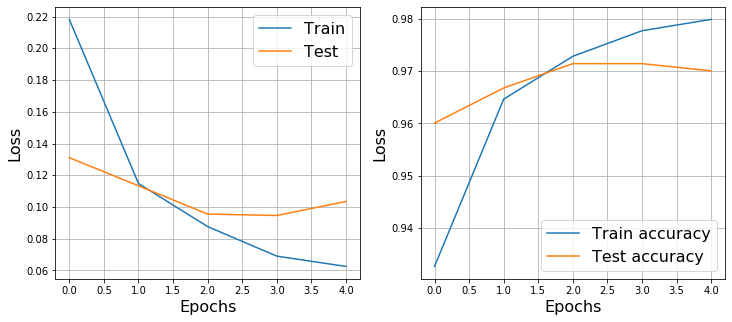

([0.21822589998052064,
  0.11482055138137295,
  0.08766827118525436,
  0.06904711506998679,
  0.06255021230029717],
 [0.13106831302276895,
  0.11339706762493411,
  0.09555113602531308,
  0.09464975859073899,
  0.10348207999869616],
 [0.9326193, 0.96463555, 0.97283113, 0.9777174, 0.97989404],
 [0.9600475, 0.96677214, 0.9714201, 0.9714201, 0.9700356])

In [17]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(num_features=next_size))
    else:
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)

train(net, train_loader, test_loader, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.049/0.078	Accuracy: 0.984/0.976


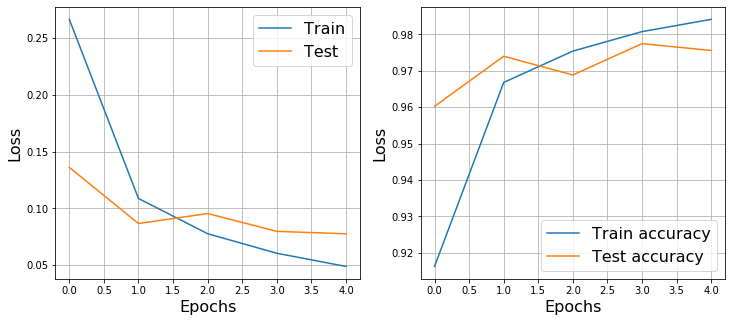

([0.2666242092704849,
  0.10872431413363864,
  0.0776487050303963,
  0.06043684474631413,
  0.04880098372286777],
 [0.13616242061687422,
  0.08664424463965092,
  0.09545175193608561,
  0.07972118802533686,
  0.07759856228728461],
 [0.916278, 0.9667955, 0.9754076, 0.98075473, 0.9841196],
 [0.96024525, 0.9739913, 0.9688489, 0.9774525, 0.9755736])

In [19]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(LayerNormalization())
    else:
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)
train(net, train_loader, test_loader, 5, 0.01)

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: